This code is a 1D test with the time dependent example given in https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/diffusion.1d.html . 
<br> We use her Pytorch (because most used to it ) and we observe the evolution of the solution, especially if it gives the analytical solution $u(x, t) = e^{-t}sin(\pi x)$.

In [20]:
#TIme dependent example of the presentation
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import os
os.environ['DDE_BACKEND'] = 'pytorch'
import torch

In [21]:
# Check if CUDA (GPU) is available and set default tensor type to cuda, but I haven't installed cuda yet
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("/////////////////\n Tensors type on GPU \n///////////////")
print("/////////////////\n Tensors type on CPU \n///////////////")

/////////////////
 Tensors type on GPU 
///////////////
/////////////////
 Tensors type on CPU 
///////////////


In [22]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import scipy


from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [23]:
# #Geometry and residual
# geom = dde.geometry.Interval(-1, 1)
# timedomain = dde.geometry.TimeDomain(0, 1)
# geomtime = dde.geometry.GeometryXTime(geom, timedomain)
# nu = 1
# c = 1


In [24]:
##Geometry 
sin = torch.sin
cos = torch.cos

end_time = 1
Lx = 1
Ly = 1
geom = dde.geometry.Rectangle([0, 0], [Lx, Ly])
timedomain = dde.geometry.TimeDomain(0, end_time)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

D = 0.001
source_box_width = 0.5

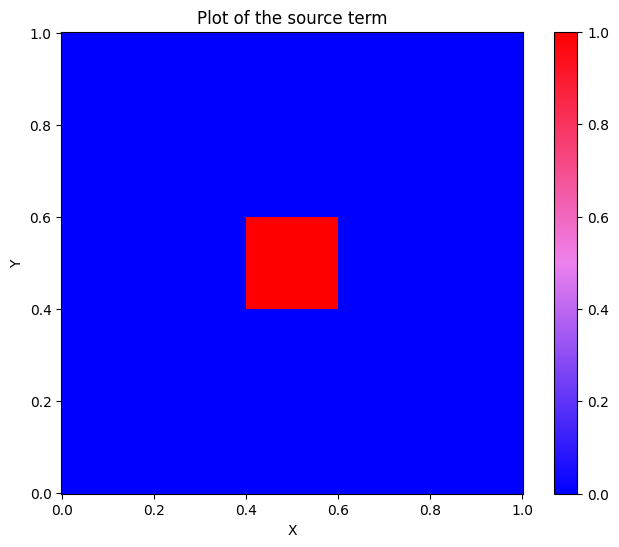

In [25]:
#The definition of the sources and plot of them

#Source places
position_source_1 = torch.tensor([Lx*0.5, Ly*0.5], dtype=torch.float) #float type otherwise it raises an error
position_source_2 = torch.tensor([Lx*0.5, Ly*0.2], dtype=torch.float) #float type otherwise it raises an error

position_source = position_source_1
width_box = 1/10

#Some functions to use for the source term
def close_to_source(p, position, width):
    '''position: Position of the middle of the source
        width: width of the source'''
    return (torch.isclose(p[:, 0], position[0], atol=width, rtol=0) * torch.isclose(p[:, 1], position[1], atol=width, rtol=0)).view((-1, 1))


def close_to_source_norm(p, position, width, norm):
    '''position: Position of the middle of the source
        width: width of the source'
        norm: order of the L_q norm. input is np.inf to have the infinite norm.
        (https://pytorch.org/docs/stable/generated/torch.linalg.vector_norm.html#torch.linalg.vector_norm)'''
    

    distance_tensor = torch.linalg.vector_norm(p[:, 0:2] - position, ord=norm, dim=1)
    return torch.isclose(distance_tensor, torch.zeros(1, dtype=torch.float), atol=width, rtol=0).view((-1, 1))




#The source_term
def source_term(p):
    return  close_to_source_norm(p, position_source, width=width_box, norm=np.inf)



#Plot of the Source
x = geom.uniform_points(250 * 250, True)
y_norm = source_term(torch.tensor(x)).cpu()



def plot_routine(plot_values, title):
    resolution_mesh = 250
    xi = np.linspace(0, Lx, resolution_mesh)
    yi = np.linspace(0, Ly, resolution_mesh)
    xi, yi = np.meshgrid(xi, yi)

    zi = griddata(points=(x[:, 0], x[:, 1]), values=plot_values[:, 0], xi=(xi, yi), method="linear")


    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        "", ["blue", "violet", "red"]
    )
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(xi, yi, zi, cmap=cmap, shading="auto")
    plt.colorbar()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

    plt.gca().set_aspect('equal', adjustable='box') # Set aspect ratio to have a rectangular plot
    plt.show()


plot_routine(y_norm, "Plot of the source term")


    

In [26]:
#Residual of the Pde and IC&BC.

def pde(p, C):
    """residual of the pde
    p contains the spatial coordinates x, y and the time t
    the i-th point (xi, yi, ti) is stored in p in the i-th line and we have
    p[i, 0] = xi; p[i, 1] = yi; p[i, 2] = ti
    C corresponds to C(p) the concentration at p"""

    # dC_x = dde.grad.jacobian(C, p, j=0)
    # dC_y = dde.grad.jacobian(C, p, j=1)
    dC_t = dde.grad.jacobian(C, p, j=2)

    dC_xx = dde.grad.hessian(C, p, i=0, j=0)
    dC_yy = dde.grad.hessian(C, p, i=1, j=1)



 
    return (
        - dC_t
        # - u[0] * dC_x
        # - u[1] * dC_y
        + D * (dC_xx + dC_yy)  
        # + source_term(p)
    )



#Conditions (Boudary & Initial)

def boundary_left(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0.0)


def boundary_right(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1.0)


def boundary_top(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 1.0)


def boundary_bottom(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 0.0)


def boundary_time(x, on_initial):
    # print(x)
    return on_initial and dde.utils.isclose(x[2], 0.0)




C_top_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_top)
C_bottom_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_bottom)
C_left_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_left)
C_right_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_right)
initial_condition = dde.icbc.IC(geomtime, lambda x:0, boundary_time)



In [39]:
position_source[0].item()

0.5

In [41]:
'''Analytical Solution of the advection-diffusion problem (from the ANACS book)'''
pos_x_1 = position_source[0].item()-width_box
pos_x_2 = position_source[0].item()+width_box
pos_y_1 = position_source[1].item()-width_box
pos_y_2 = position_source[1].item()+width_box

def analytical_sol(p):
    x, y, t = p
    # f = lambda tau, v, u: S /(4*np.pi*D*(t-tau))*np.exp(-((x-u)**2 + (y-v)**2)/(4*D*(t-tau)))
    f = lambda y_, x_: np.exp(-((x-x_)**2 + (y-y_)**2)/(4*D*(t)))
    return (4*np.pi*t)*scipy.integrate.dblquad(f, pos_x_1, pos_x_2, pos_y_1, pos_y_2)[0]




Some **documentation for the TimePDE**: https://deepxde.readthedocs.io/en/latest/modules/deepxde.data.html#deepxde.data.pde.PDE  .
Go check the deepxde.data.pde module and then, timepde (cf link column on the site). One can e.g set a specific initialization of points (train_distribution parameter).

In [28]:
#Data and model:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [C_top_bc,
     C_bottom_bc,
     C_left_bc,
     C_right_bc,
     initial_condition,
    ],
    num_domain=500,
    num_boundary=500,
    num_initial = 200,
    num_test=100,
)

layers = [3] + [40] *3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layers, activation, initializer)
model = dde.Model(data, net)

Here is **the documentation of model.compile** : "https://deepxde.readthedocs.io/en/latest/modules/deepxde.html#deepxde.model.Model.compile". In the loss and loss_weights parameters, one must order the weights like this : weights for the pde, weights for each element of bcs. bcs is the ic bc list in the input of data. The weights for the bcs list is ordered the same way as bcs. 


Compiling model...
'compile' took 0.000480 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [8.93e-03, 3.00e-02, 8.52e-03, 2.72e-03, 4.66e-02, 2.74e-02]    [8.87e-03, 3.00e-02, 8.52e-03, 2.72e-03, 4.66e-02, 2.74e-02]    []  
1000      [1.61e-06, 2.56e-07, 4.54e-07, 2.55e-07, 2.91e-07, 2.54e-07]    [8.25e-07, 2.56e-07, 4.54e-07, 2.55e-07, 2.91e-07, 2.54e-07]    []  
2000      [1.02e-06, 7.94e-08, 1.70e-07, 8.60e-08, 1.28e-07, 4.93e-08]    [7.66e-07, 7.94e-08, 1.70e-07, 8.60e-08, 1.28e-07, 4.93e-08]    []  
3000      [7.38e-07, 6.28e-08, 1.10e-07, 6.35e-08, 8.79e-08, 1.52e-08]    [5.48e-07, 6.28e-08, 1.10e-07, 6.35e-08, 8.79e-08, 1.52e-08]    []  
4000      [4.95e-07, 5.23e-08, 7.60e-08, 4.41e-08, 6.64e-08, 1.09e-08]    [3.79e-07, 5.23e-08, 7.60e-08, 4.41e-08, 6.64e-08, 1.09e-08]    []  
5000      [3.85e-07, 4.63e-08, 5.51e-08, 6.34e-08, 6.88e-08, 9.49e-09]

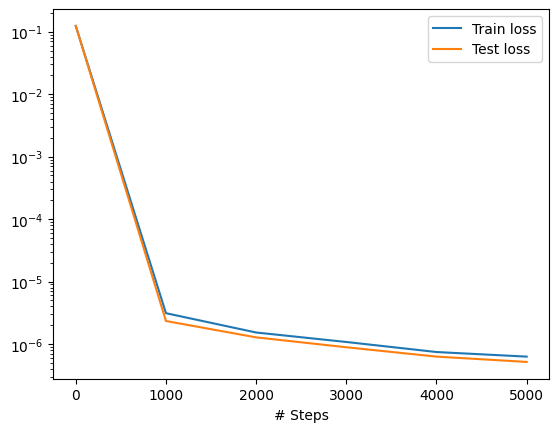

In [29]:
#Computations and graph
# model.compile("adam", lr=0.001, loss= 'MSE', loss_weights=[0.01, 1, 1])
# losshistory, train_state = model.train(iterations=10000)
# dde.saveplot(losshistory, train_state, issave=True, isplot=True)


model.compile("adam", lr=0.001, loss='MSE', loss_weights=[1, 1, 1, 1, 1, 1])
losshistory, train_state = model.train(epochs=5000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


**Some difference and solution plots**

Some Matplotlib link for placing colorbars: https://matplotlib.org/stable/users/explain/axes/colorbar_placement.html

[0.  0.  0.7]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273


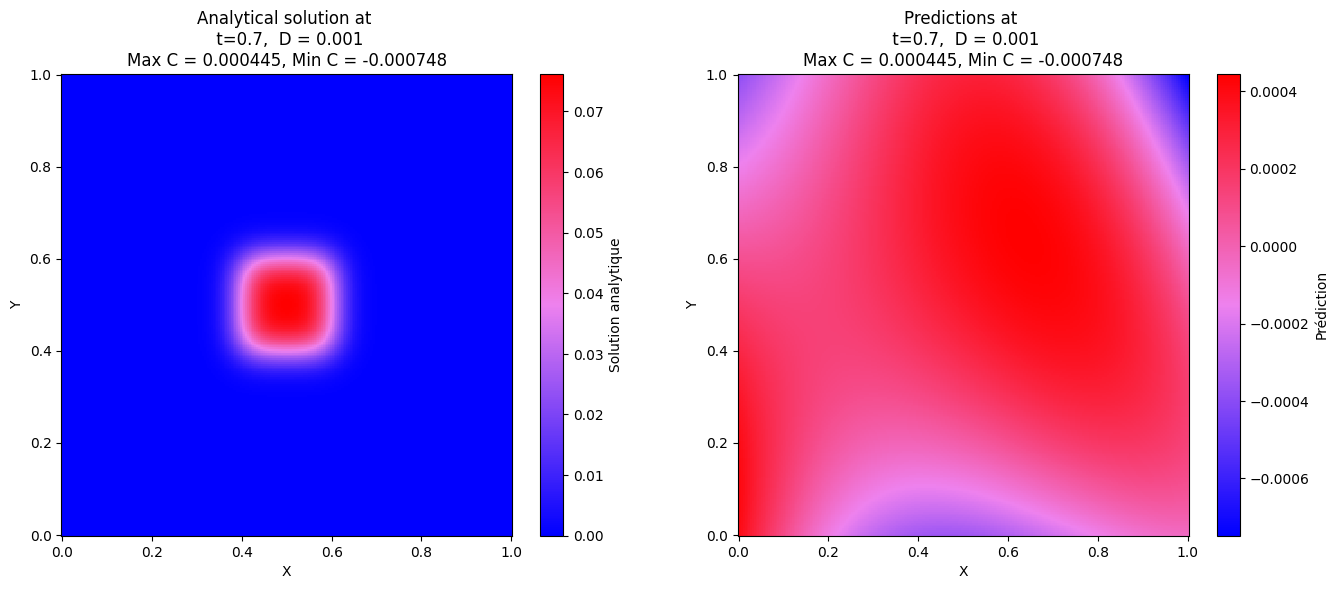

In [42]:
#Display of the Analytical and computed solution at a time t_1


t_1 = 0.7

# Define the spatial domain where you want to evaluate the function
# x = np.linspace(-1, 1, 100)

x = geom.uniform_points(250 * 250, True)
C_max = 0.7 #Max in absolute value to scale the color of the graph
Use_max = False
resolution_mesh = 250
xi = np.linspace(0, Lx, resolution_mesh)
yi = np.linspace(0, Ly, resolution_mesh)
xi, yi = np.meshgrid(xi, yi)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", ["blue", "violet", "red"]
)


# Evaluate the function u(x, t) at the specified time t_1 and spatial domain x
# u_x_t1 = model.predict(np.transpose(np.vstack([x, t_1*np.ones_like(x)]))) #Makes a vertical 2d vector
# print(np.shape(u_x_t1))

p = np.c_[x, np.array([t_1] * x.shape[0])]
print(p[0])

# axs[0].plot(x, f(x))
u_t1 = model.predict(p)[:,0]



#analytical solution
# a_x_t1 = analytical_sol(x, t_1*np.ones_like(x), N= 33)
a_t1 = np.ones(u_t1.shape)
counter = 0
for pts in p:
    a_t1[counter] = analytical_sol(pts)
    print(counter)
    counter+=1

#The plot
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

zi = griddata((x[:, 0], x[:, 1]), u_t1, (xi, yi), method="linear")
zi_a = griddata((x[:, 0], x[:, 1]), a_t1, (xi, yi), method="linear")

plt.figure(figsize=(8, 6))
if Use_max:
    ax_0_pcolormesh = axs[0].pcolormesh(xi, yi, zi_a, cmap=cmap, vmin=-1*C_max, vmax=C_max, shading="auto")
    ax_1_pcolormesh = axs[1].pcolormesh(xi, yi, zi, cmap=cmap, vmin=-1*C_max, vmax=C_max, shading="auto")
else:
    ax_0_pcolormesh = axs[0].pcolormesh(xi, yi, zi_a, cmap=cmap, shading="auto")
    ax_1_pcolormesh = axs[1].pcolormesh(xi, yi, zi, cmap=cmap, shading="auto")
    
fig.colorbar(ax_0_pcolormesh, label="Solution analytique")
fig.colorbar(ax_1_pcolormesh, label="Prédiction")

axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")

title_plot_0 = "Analytical solution " + "at \n t={time},  D = {Diffusion}\n" + "Max C = {max}, Min C = {min}"
title_plot = "Predictions " + "at \n t={time},  D = {Diffusion}\n" + "Max C = {max}, Min C = {min}"

axs[0].set_title(title_plot_0.format(time=t_1, Diffusion = D, max = int(np.max(u_t1)*10e5)/10e5, min = int(np.min(u_t1)*10e5)/10e5))
axs[1].set_title(title_plot.format(time=t_1, Diffusion = D, max = int(np.max(u_t1)*10e5)/10e5, min = int(np.min(u_t1)*10e5)/10e5))

plt.gca().set_aspect('equal', adjustable='box') # Set aspect ratio to have a rectangular plot
plt.close()
plt.show()


In [22]:
p.shape

(62500, 3)

In [13]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


In [14]:
# Define the time domain
t = np.linspace(0, 1, 30)
delta_t = 0.1 # time step for the animation
T_anim = end_time #animation end time
x = geom.uniform_points(250 * 250, True)



resolution_mesh = 250
xi = np.linspace(0, Lx, resolution_mesh)
yi = np.linspace(0, Ly, resolution_mesh)
xi, yi = np.meshgrid(xi, yi)

p = np.c_[x, np.array([0] * x.shape[0])]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", ["blue", "violet", "red"]
)

# Initialize the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))


u_t1 = model.predict(p)[:,0]
a_t1 = np.ones(u_t1.shape)
# a_x_t1 = analytical_sol(x, 0*np.ones_like(x), N=Order)
# diff = a_x_t1 - u_x_t1[:, 0]


#initilize the colormeshes
zi = griddata((x[:, 0], x[:, 1]), u_t1, (xi, yi), method="linear")
zi_a = griddata((x[:, 0], x[:, 1]), a_t1, (xi, yi), method="linear")

pcolormesh_a = axs[0].pcolormesh(xi, yi, zi_a, cmap=cmap, shading="auto")
pcolormesh_u = axs[1].pcolormesh(xi, yi, zi, cmap=cmap, shading="auto")

fig.colorbar(pcolormesh_a, label="Solution analytique")
fig.colorbar(pcolormesh_u, label="Prédiction")


# Update function for the animation
def update(frame):
    #Two graphs
    t_1 = t[frame]
    
    
    p = np.c_[x, np.array([t_1] * x.shape[0])]
    u_t1 = model.predict(p)[:,0]
    a_t1 = np.ones(u_t1.shape)
    
    zi = griddata((x[:, 0], x[:, 1]), u_t1, (xi, yi), method="linear")
    zi_a = griddata((x[:, 0], x[:, 1]), a_t1, (xi, yi), method="linear")

    # line_analytical.set_data(x, a_x_t1)
    # line_computed.set_data(x, u_x_t1)
    
    axs[0].set_title('Analytical solution at time {}'.format(t_1))
    axs[1].set_title('Computed solution at time {}'.format(t_1))
    
    pcolormesh_a.set_array(zi_a.ravel())
    pcolormesh_u.set_array(zi.ravel())
    return pcolormesh_a, pcolormesh_u




# Create the animations

animation = FuncAnimation(fig, update, frames=len(t))
plt.close() #to avoid having another plot after the animation
# Show the animation
HTML(animation.to_jshtml())




In [15]:
# Define the time domain
t = np.linspace(0, 1, 30)
delta_t = 0.1 # time step for the animation
T_anim = end_time #animation end time
x = geom.uniform_points(250 * 250, True)



resolution_mesh = 250
xi = np.linspace(0, Lx, resolution_mesh)
yi = np.linspace(0, Ly, resolution_mesh)
xi, yi = np.meshgrid(xi, yi)

p = np.c_[x, np.array([0] * x.shape[0])]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", ["blue", "violet", "red"]
)

# Initialize the figure and subplots

u_t1 = model.predict(p)[:,0]
a_t1 = np.ones(u_t1.shape)
# a_x_t1 = analytical_sol(x, 0*np.ones_like(x), N=Order)

diff = a_t1 - u_t1


#initilize the colormeshes
fig, ax= plt.subplots(1, 1)
zi_diff = griddata((x[:, 0], x[:, 1]), diff, (xi, yi), method="linear")

pcolormesh_diff = ax.pcolormesh(xi, yi, zi_diff, cmap=cmap, shading="auto")

fig.colorbar(pcolormesh_diff, label="Difference")


# Update function for the animation
def update(frame):
    #Two graphs
    t_1 = t[frame]
    
    
    p = np.c_[x, np.array([t_1] * x.shape[0])]
    u_t1 = model.predict(p)[:,0]
    a_t1 = np.ones(u_t1.shape)
    diff =  a_t1 - u_t1
    zi_diff = griddata((x[:, 0], x[:, 1]), diff, (xi, yi), method="linear")
    
    ax.set_title('Analytical solution at time {}'.format(t_1))
    
    pcolormesh_diff.set_array(zi_diff.ravel())
    return pcolormesh_diff, 




# Create the animations

animation = FuncAnimation(fig, update, frames=len(t))
plt.close() #to avoid having another plot after the animation
# Show the animation
HTML(animation.to_jshtml())





**Error Checks**

In [ ]:
from numpy import linalg

In [16]:
'''L2 difference computation'''
space_step = 100
time_step = 100


x = geomtime.uniform_points(space_step**2*time_step, boundary=True)
y_true = analytical_sol(x[:,0], x[:,1], N=500)
y_pred = model.predict(x)[:, 0] #Watch out: shape of model.predict is  (M, 1).
print(np.shape(y_pred))
print(np.shape(y_true))


error= dde.metrics.l2_relative_error(y_true, y_pred) 
# print(y_pred)
print("\nDeepXDE-made relative error: ", error)


#Hand-made verifications
error_hand_made = np.linalg.norm(y_true-y_pred)/np.linalg.norm(y_true) #default 2-norm
print("\nHand-made relative error ", error_hand_made)

TypeError: analytical_sol() got an unexpected keyword argument 'N'